In [57]:
import os
from dotenv import load_dotenv

In [58]:
load_dotenv()

True

In [59]:
from langgraph.graph import StateGraph, END
from typing import Annotated,TypedDict
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults

In [60]:
tool = TavilySearchResults(tavily_api_key=os.environ["TAVILY_API_KEY"],max_results=2)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [61]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage],operator.add]

In [62]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver.from_conn_string(":memory:")

In [63]:
class Agent:
    def __init__(self,model,tools,checkpointer,system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm",self.call_groq)
        graph.add_node("action",self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True:"action",False:END}
        )
        graph.add_edge("action","llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name:t for t in tools}
        self.model = model
    
    def exists_action(self,state:AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls)>0


    def call_groq(self,state:AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages":[message]}
    
    def take_action(self,state:AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling {t}")
            if not t['name'] in self.tools:
                print("Tool not available")
                result = "Tool not available"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'],name=t['name'],content=str(result)))
        return {"messages":results}

In [64]:
# from groq import Groq
# client = Groq(api_key=os.getenv("GROQ_API_KEY"))
# class GroqLLM:
#     def __init__(self, client, model):
#         self.client = client
#         self.model = model

#     def __call__(self, query):
#         response = self.client.chat.completions.create(
#             model=self.model,
#             messages=[{"role": "user", "content": query}]
#         )
#         return response.choices[0].message.content

# # Initialize like this
# llm = GroqLLM(client, "llama-3.3-70b-versatile")

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-70b-8192", api_key=os.getenv("GROQ_API_KEY"))

In [ ]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = llm

abot = Agent(model, [tool], system=prompt, checkpointer=memory)

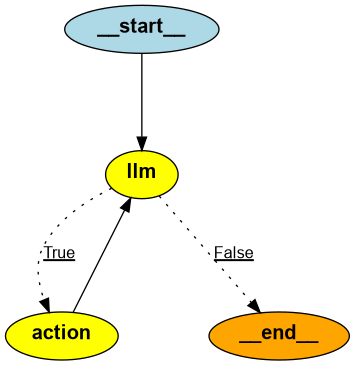

In [66]:
from IPython.display import Image
Image(abot.graph.get_graph().draw_png())

In [67]:
# query = "Who won the ICC Champions trophy in 2013 and what is the capital of that country?"
# messages = [HumanMessage(content=query)]
# result = abot.graph.invoke({"messages":messages})

In [68]:
result

{'messages': [HumanMessage(content='Who won the ICC Champions trophy in 2013 and what is the capital of that country?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Let me look up the information for you!\n\nAccording to my search, India won the ICC Champions Trophy in 2013.\n\nAnd, the capital of India is New Delhi.\n\nWould you like to know more about the tournament or India?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 99, 'total_tokens': 147, 'completion_time': 0.137142857, 'prompt_time': 0.002778006, 'queue_time': 0.056612824, 'total_time': 0.139920863}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--b147b1e8-47e9-4226-abef-295e9ec02026-0', usage_metadata={'input_tokens': 99, 'output_tokens': 48, 'total_tokens': 147})]}

In [69]:
print(result["messages"][-1].content)

Let me look up the information for you!

According to my search, India won the ICC Champions Trophy in 2013.

And, the capital of India is New Delhi.

Would you like to know more about the tournament or India?


In [70]:
messages = [HumanMessage("Who is the top most ranked chess player in India")]


In [78]:
with SqliteSaver.from_conn_string(":memory:") as memory:
    thread = {
        "configurable": {"thread_id": "1"},
        "config": {
            "checkpointer": memory
        }
    }

    for event in abot.graph.stream({"messages": messages}, thread):
        for v in event.values():
            print(v["messages"])

ProgrammingError: Cannot operate on a closed database.

In [ ]:
for event in abot.graph.stream({"messages":messages},thread):
    for v in event.values():
        print(v["messages"])

AttributeError: '_GeneratorContextManager' object has no attribute 'get_next_version'